##### To use this notebook you will need LyaPlotter: https://github.com/cramirezpe/LyaPlotter.git
##### and modules-corrf-analysis: https://github.com/cramirezpe/modules-corrf-analysis.git

In [1]:
%matplotlib inline
from importlib import reload
import sys
from LyaPlotter.computations import Computations
from LyaPlotter.plotter import Plotter
from LyaPlotter.sims import CoLoReSim, LyaCoLoReSim, QuickQuasarsSim
import glob
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from matplotlib.gridspec import GridSpec
from CoLoRe_corrf_analysis.fitter import Fitter
from pathlib import Path 
import fitsio 
plt.style.use('tableau-colorblind10') 
from CoLoRe_corrf_analysis.cf_helper import CFComputations, CFComputationsAbacus
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

In [2]:
#extract the output from galaxies and quasars performing a downsampling of 99.9% for galaxies and 95% for quasars.
sim = CoLoReSim(0, '/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results')
gal_file = sim.get_Sources(ifiles=list(range(128)),source=2, downsampling=0.001)
qso_file = sim.get_Sources(ifiles=list(range(128)),source=1, downsampling=0.05)

# extract the input redshift and dn/dz of both tracers
z_gal, n_gal = np.loadtxt('/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/input_files/scaled_nz_dz.txt', unpack=True)
z_qso, n_qso = np.loadtxt('/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/input_files/Nz_qso_130618_2_colore1_hZs.txt', unpack=True)
full_sky_deg = 4/np.pi*180**2

In [ ]:
# print how many galaxies, qso
N_gal = gal_file.N_obj
N_qso = qso_file.N_obj

In [7]:
print("N GAL: ", N_gal)
print("N QSO: ", N_qso)

print("N GAL tot: ", N_gal/0.001)
print("N QSO tot: ", N_qso/0.05)

# print number density:
print("N GAL per arcmin^2: ", N_gal/0.001/(full_sky_deg*60**2))
print("N QSO per arcmin^2: ", N_qso/0.05/(full_sky_deg*60**2))

N GAL:  7151451
N QSO:  584865
N GAL tot:  7151451000.0
N QSO tot:  11697300.0
N GAL per arcmin^2:  48.15446228589544
N QSO per arcmin^2:  0.07876404266725798


In [8]:
qso_file.healpixels[:5]

array([515,   3,   3,   3, 515])

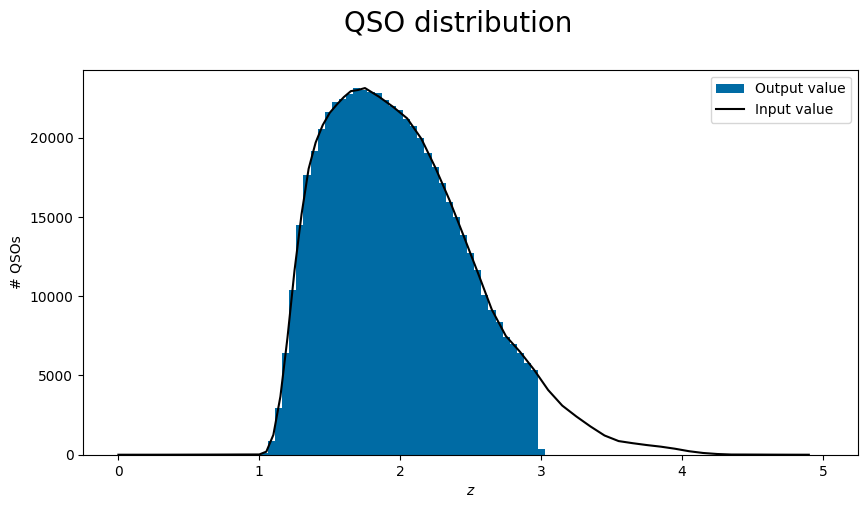

In [4]:
#plot comparing the input vs the output values of the quasars
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 

bins = np.linspace(0, 5, 100)
width = bins[3] - bins[2]

_ = qso_file.plot_dist(ax=ax, bins=bins, density=False, label='Output value')

ax.plot(z_qso, n_qso * full_sky_deg * width * 0.05, color='k', label='Input value')

ax.set_ylabel('# QSOs')
ax.legend()

plt.suptitle('QSO distribution', fontsize=20, y=1)

plt.show()

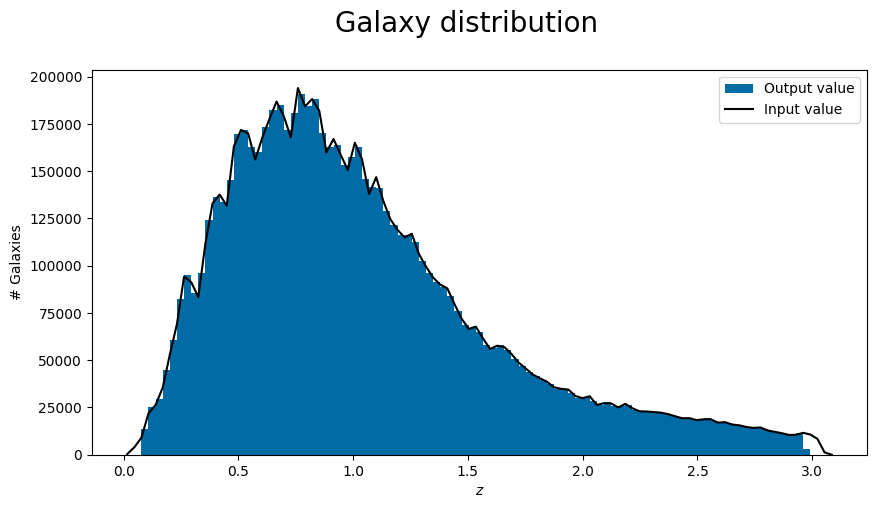

In [6]:
#similarly comparing the input vs the output values of the galaxies

fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 

bins = np.linspace(1.55000000e-02, 3.08450000e+00, 100)
width = bins[3] - bins[2]

_ = gal_file.plot_dist(ax=ax, bins=bins, density=False, label='Output value')

ax.plot(z_gal, n_gal * full_sky_deg * width* 0.001, color='k', label='Input value')

ax.set_ylabel('# Galaxies')
ax.legend()

plt.suptitle('Galaxy distribution', fontsize=20, y=1)

plt.show()


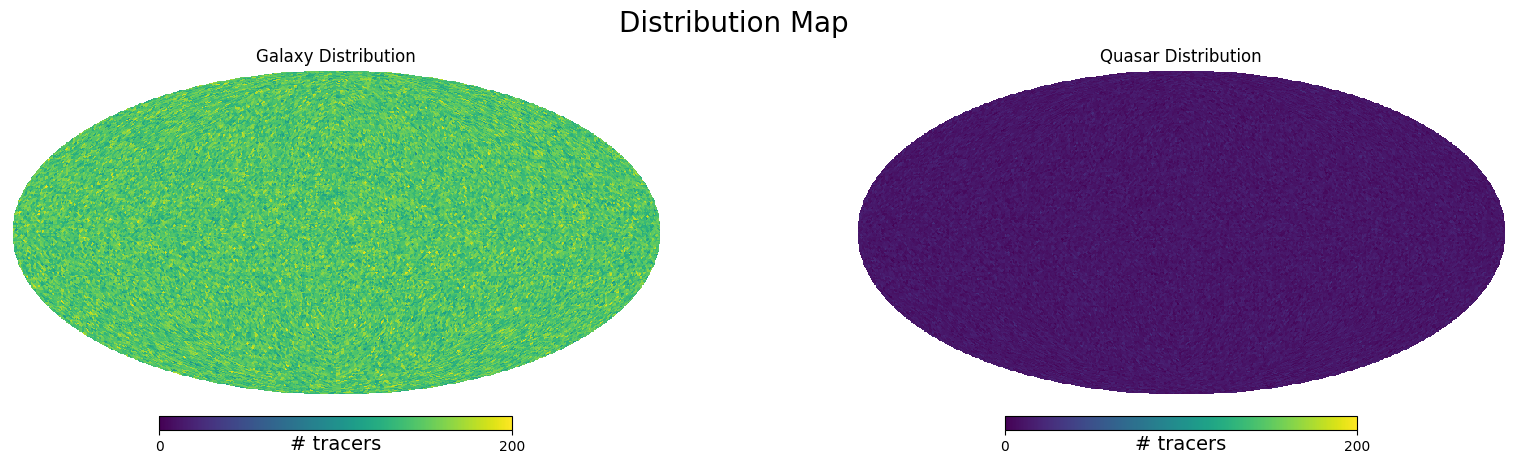

In [7]:
fig, ax_array = plt.subplots(1, 2, figsize=(20, 5))
ax1, ax2 = ax_array

min_count = 0
max_count = 200
bins = np.linspace(min_count, max_count, 70)

for file, ax, title in zip([gal_file, qso_file], [ax1, ax2], ["Galaxy Distribution", "Quasar Distribution"]):
    nside = 64
    npix = hp.nside2npix(nside)
    pix = hp.ang2pix(nside,
                     np.radians(90 - file.DEC),
                     np.radians(file.RA))
    n = np.bincount(pix, minlength=npix)
    n[n > max_count] = max_count

    plt.axes(ax)
    hp.mollview(n, title=title, min=min_count, max=max_count, hold=True, unit='# tracers')

plt.suptitle('Distribution Map', fontsize=20, y=1)
plt.show()


# Measuring the bias

#### Now we perform a fit of the correlation function to obtain the effective bias

In [2]:
rsd = False
zmin = 2
zmax = 2.2

In [3]:
#get correlation function from box for z_eff~2.1

corrf_outputs_glob = Path(
    "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box_0/gal_box/Corrf/2.0_2.2"
).glob(f"source_2no_rsd*/results")

colore_boxes = []
for result in corrf_outputs_glob:
    colore_boxes.append(CFComputations(
        results_path=result,
    ))
print(np.shape(colore_boxes))

(48,)


In [4]:
# The model to fit the or correlations takes as an input a CoLoRe box
# the model will be generated matching the cosmology of the given input box.
colore_box = Path(
    "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box_0/lya_box/results"
)

model = ComputeModelsCoLoRe(
    box_path=colore_box,
    source=1, 
    param_cfg_filename=colore_box.parent / "param.cfg", 
    snapshot=False, 
    apply_lognormal=False,
    nz_filename = '/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/input_files/Nz_qso_130618_2_colore1_hZs.txt'
)



z = model.get_zeff(zmin, zmax)
print(z)

2.0958611368783746


In [16]:
# A fitter takes as input both the boxes we want to use to read the data and the model we want to fit

colore_fit = Fitter(
    boxes=colore_boxes,
    z=z,
    poles=[0,], # Multipoles to include in the fit (we are fitting only monopole now since norsd)
    theory=model, 
    rsd=rsd,
    rmin={0: 10}, 
    rmax={0: 30},
)

In [13]:
model.bias_filename='/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/input_files/Bz_qso_G18.txt'

In [17]:
#result of the fit
colore_fit.run_fit(
    bias = dict(vary=True),
)

In [8]:
#comparing to input bias

z_bias, bias = np.loadtxt('/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/input_files/bias_dc2.txt', unpack=True)

z_val = z_bias[34]
bias_val = bias[34]

print(f"For z= {z_val}, the input bias is {bias_val}.")


For z= 2.0700000000000003, the input bias is 2.5085169342554905.


In [10]:
from CoLoRe_corrf_analysis.plot_methods import Plots

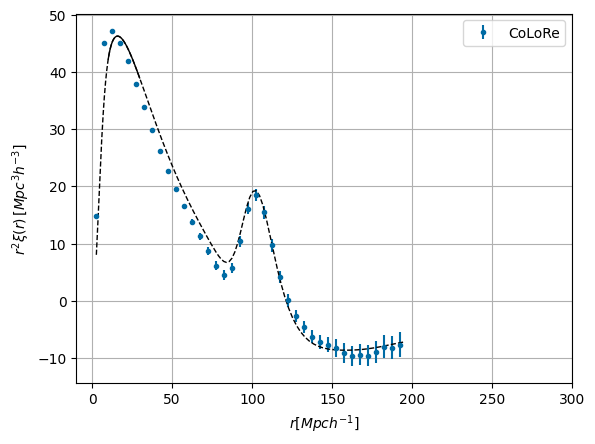

In [18]:
# Finally, we can plot the model with the data at the same time.

fig, ax = plt.subplots()

xis = np.array([box.compute_npole(n=0) for box in colore_boxes])

ax.errorbar(
    colore_boxes[0].savg, 
    xis.mean(axis=0)*colore_boxes[0].savg**2,
    yerr=xis.std(axis=0, ddof=1)*colore_boxes[0].savg**2 / np.sqrt(len(colore_boxes)),
    label="CoLoRe",
    fmt='.',
)


    
Plots.plot_best_fit(
    colore_fit,
    pole=0, # Multipole we want to plot.
    ax=ax, # We pass the axis where we want to plot.
    plot_args=dict(c='k', lw=1)
)
    

ax.grid()
ax.set_xlim(-10, 300)
ax.set_xlabel(r"$r [Mpc h^{-1}]$")
ax.set_ylabel(r"$r^2 \xi(r) \, [Mpc^3 h^{-3}]$")
ax.legend()

# LyaCoLoRe skewers

In [3]:
from astropy.io import fits

In [4]:
hdu=fits.open('/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers/output_files/13/1375/transmission-16-1375.fits.gz')

In [5]:
wave=hdu[2].data
ra=hdu[1].data['RA']
dec=hdu[1].data['DEC']
z=hdu[1].data['Z']

In [8]:
print(z)

[2.8438148 2.955055  2.8929677 ... 1.8095151 2.0174305 2.1474366]


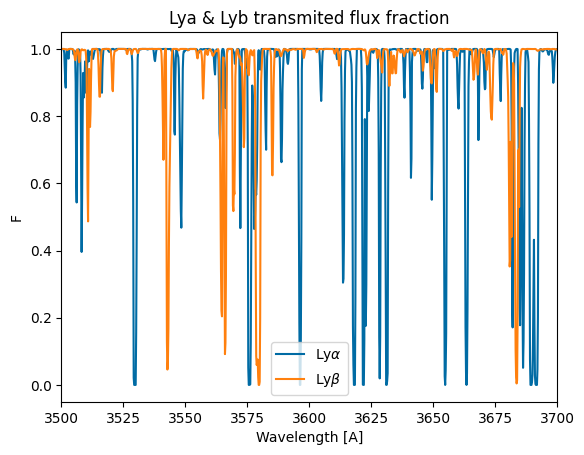

In [6]:
fig, axs = plt.subplots(1,1)
plt.plot(wave,hdu['F_LYA'].data[0],label=r'Ly$\alpha$')
plt.plot(wave,hdu['F_LYB'].data[0],label=r'Ly$\beta$')


plt.xlabel('Wavelength [A]')
plt.ylabel('F')
plt.xlim(3500,3700)
plt.ylim(-0.05,1.05)
plt.title('Lya & Lyb transmited flux fraction')
plt.legend()
plt.show()

(1.75, 2.9)

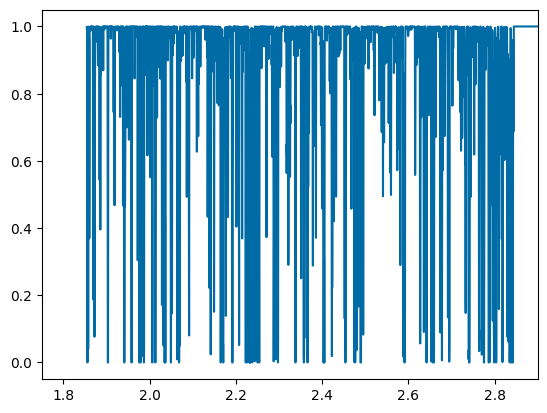

In [11]:
emit = 1215.67
red = (wave-emit)/emit
plt.plot(red, hdu['F_LYA'].data[0])
plt.xlim([1.75,2.9])

In [14]:
red[0],red[-1]

(1.854393, 4.346681)

In [16]:
hp.nside2resol(512,arcmin=True)

6.870972823634812